In [1]:
# system
import os
import importlib

# scipy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# nutrig
import flt.template_FLT
from flt.template_FLT import *

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

In [2]:
plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/plots'
savefig  = False

Load in background and signal datasets

In [ ]:
bkg_train_file = '/sps/grand/pcorrea/nutrig/database/bkg/bkg_dataset_nutrig_gp13_train_seed_300.npz'

with np.load(bkg_train_file) as f:
    bkg_traces        = f['traces']
    bkg_pretrig_flags = f['pretrig_flags']
    bkg_pretrig_times = f['pretrig_times']

sig_train_file = '/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_old_gp13_train_seed_300.npz'

with np.load(sig_train_file) as f:
    sig_traces          = f['traces']
    sig_snr             = f['snr']
    sig_inj_pulse_times = f['inj_pulse_times']
    sig_pretrig_flags   = f['pretrig_flags']
    sig_pretrig_times   = f['pretrig_times']

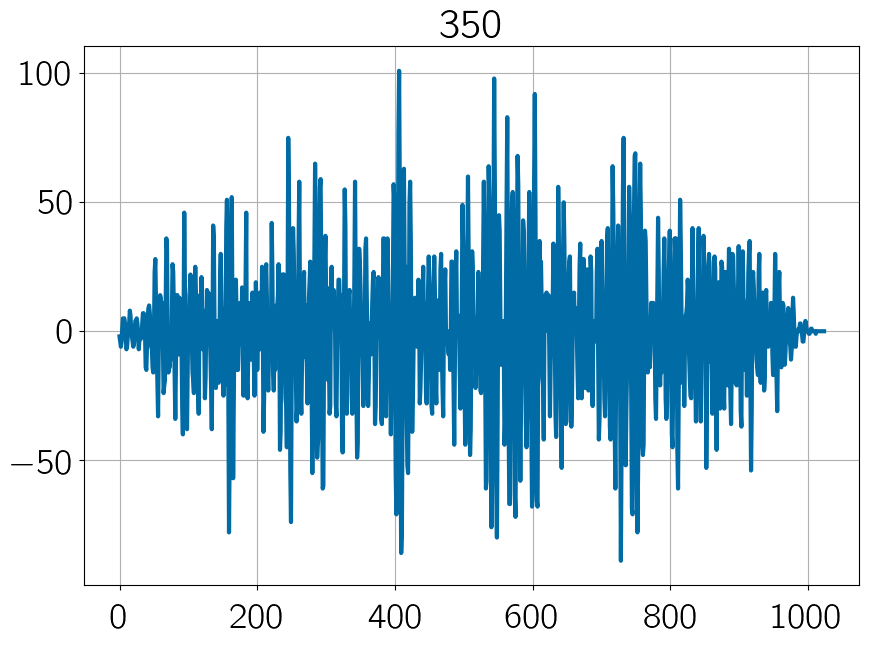

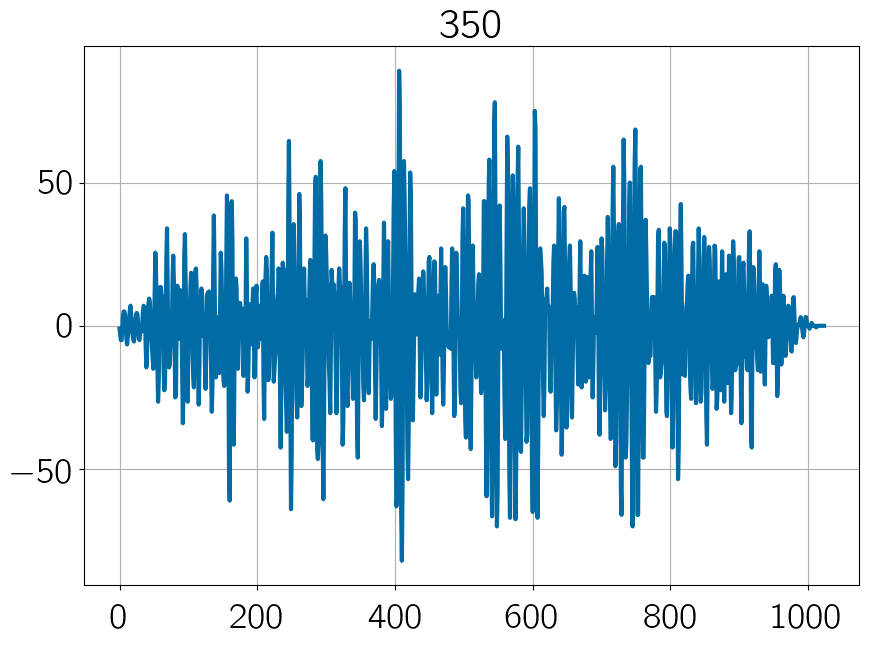

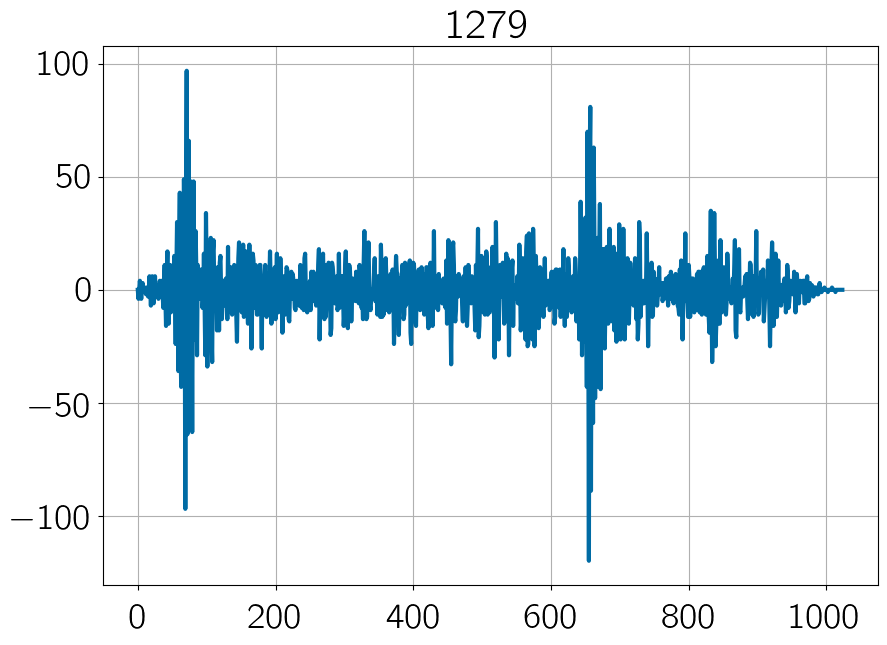

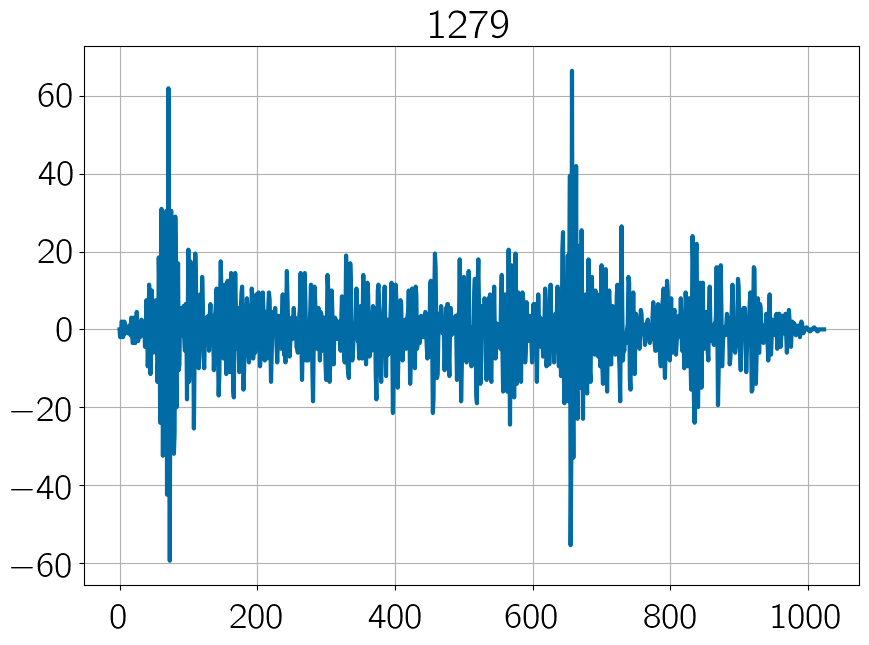

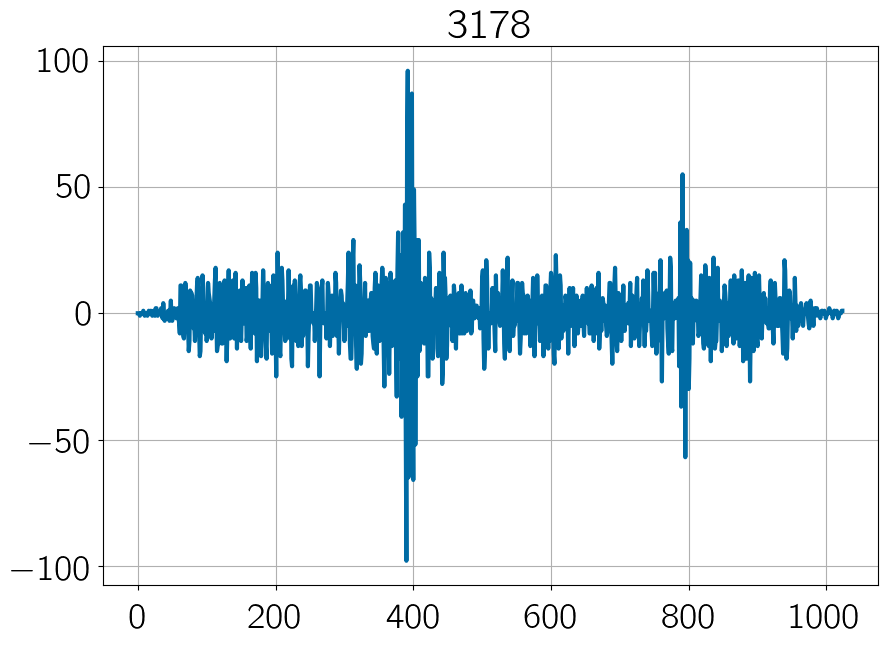

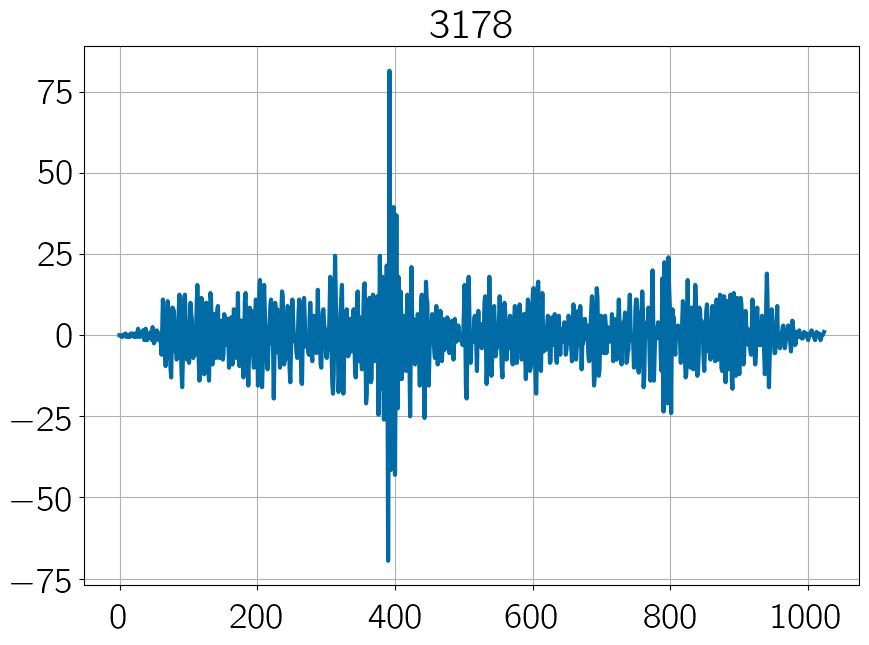

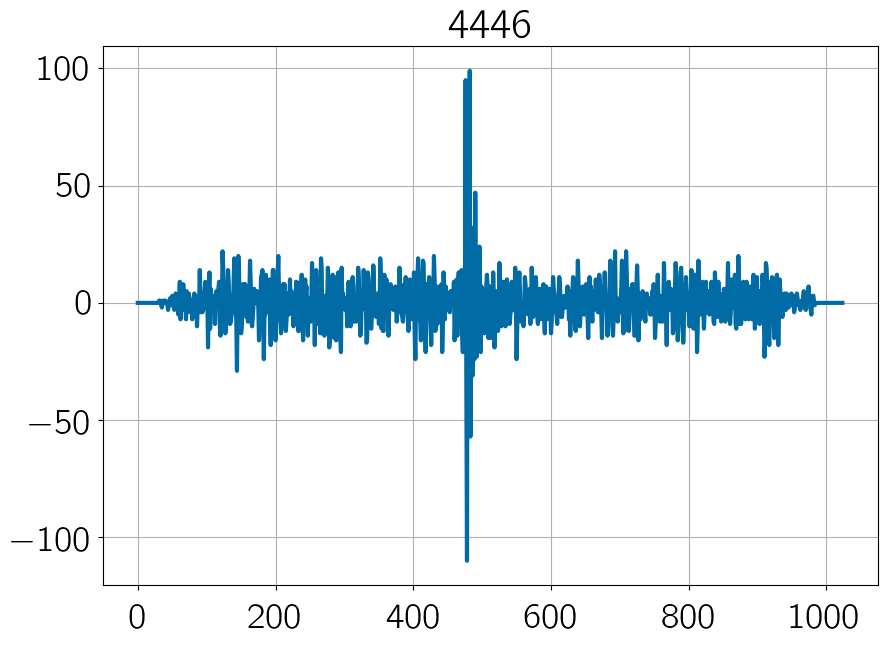

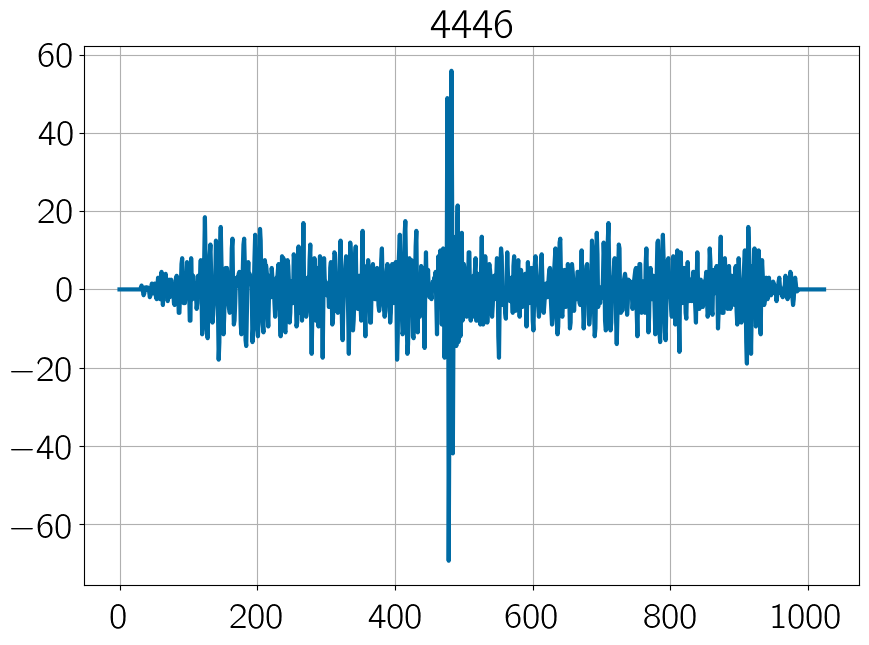

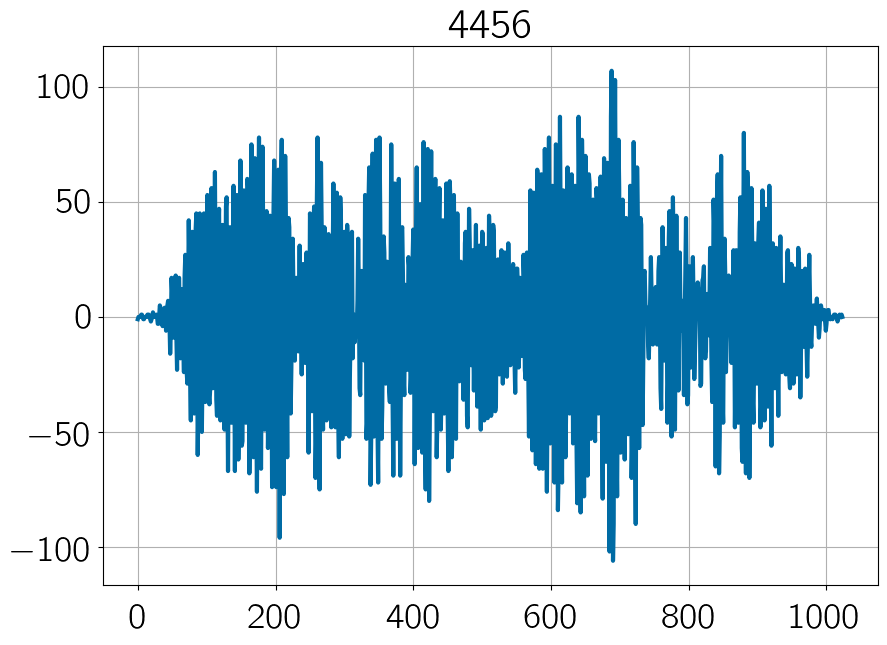

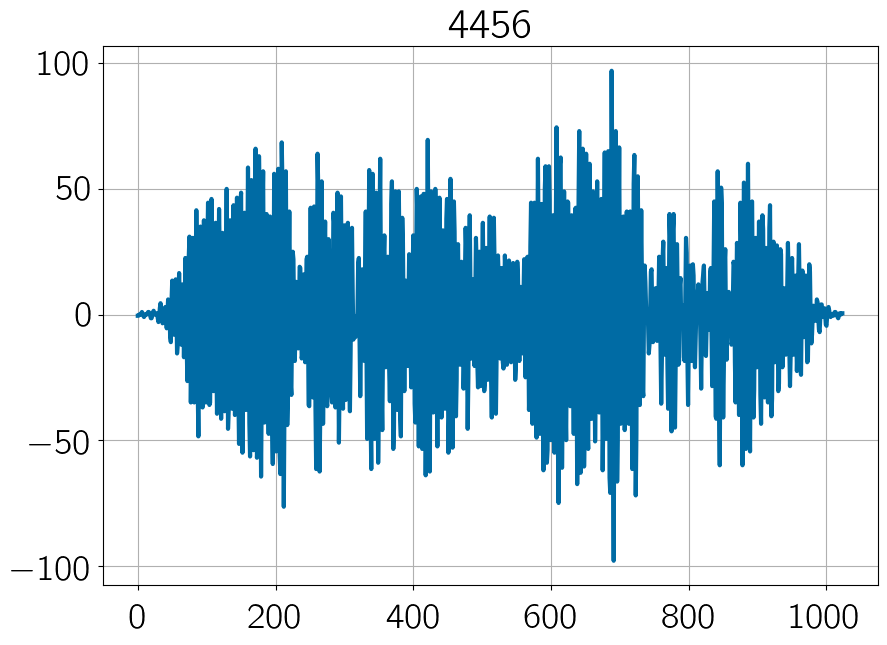

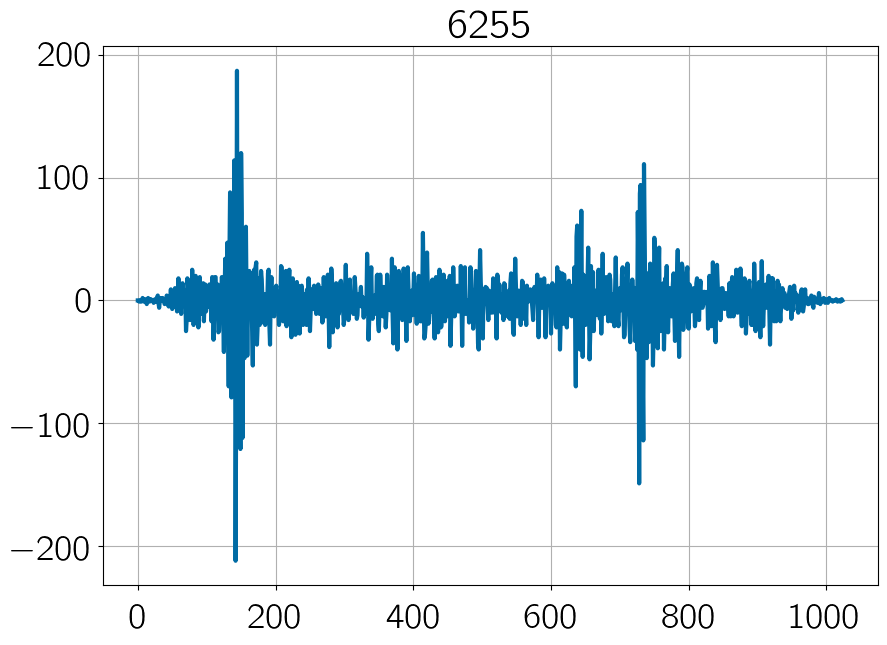

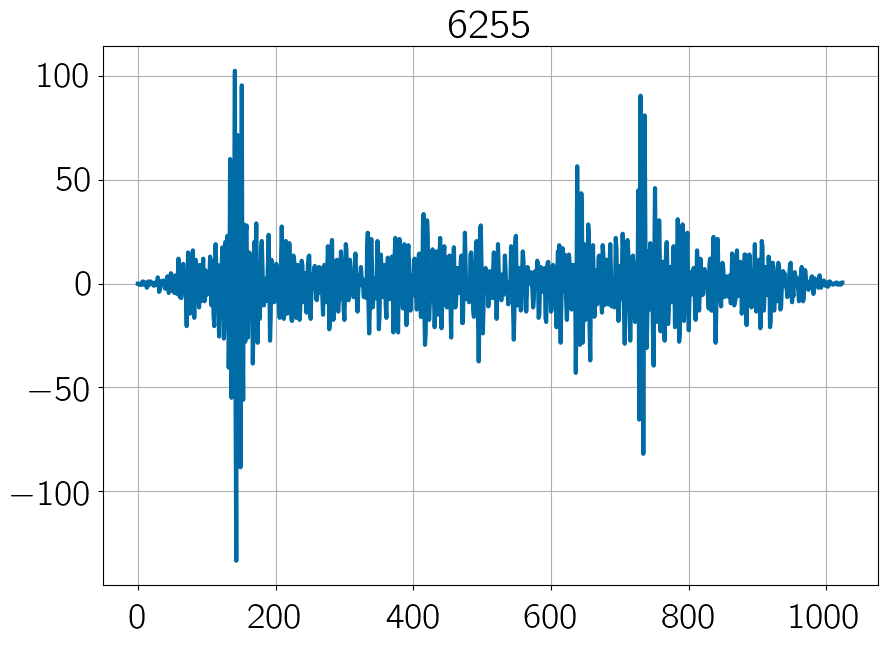

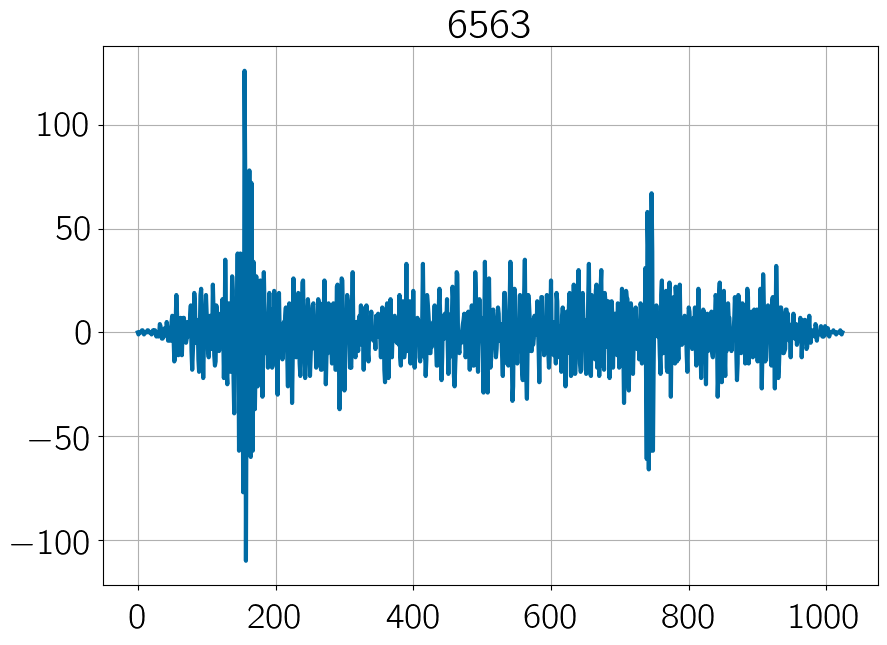

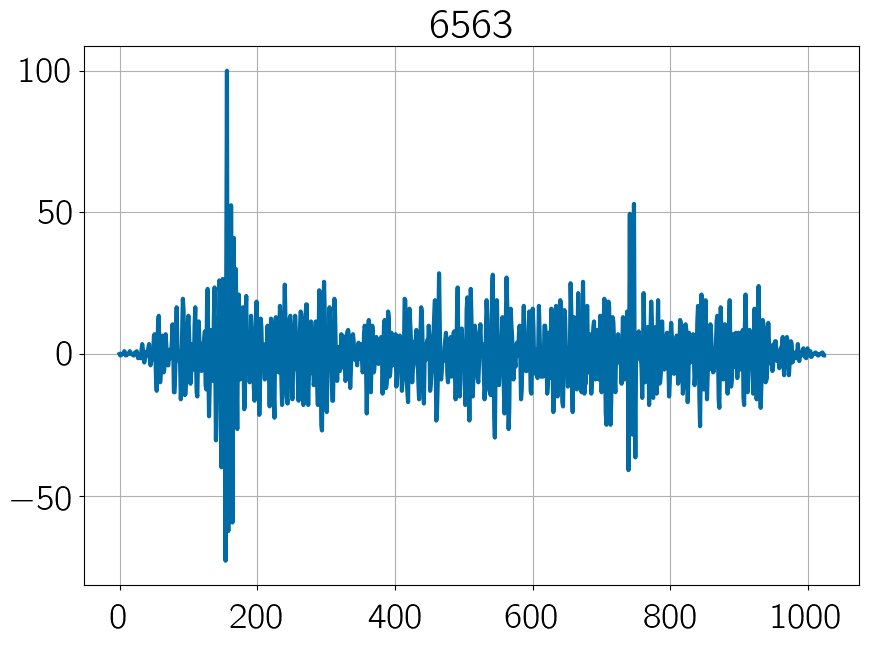

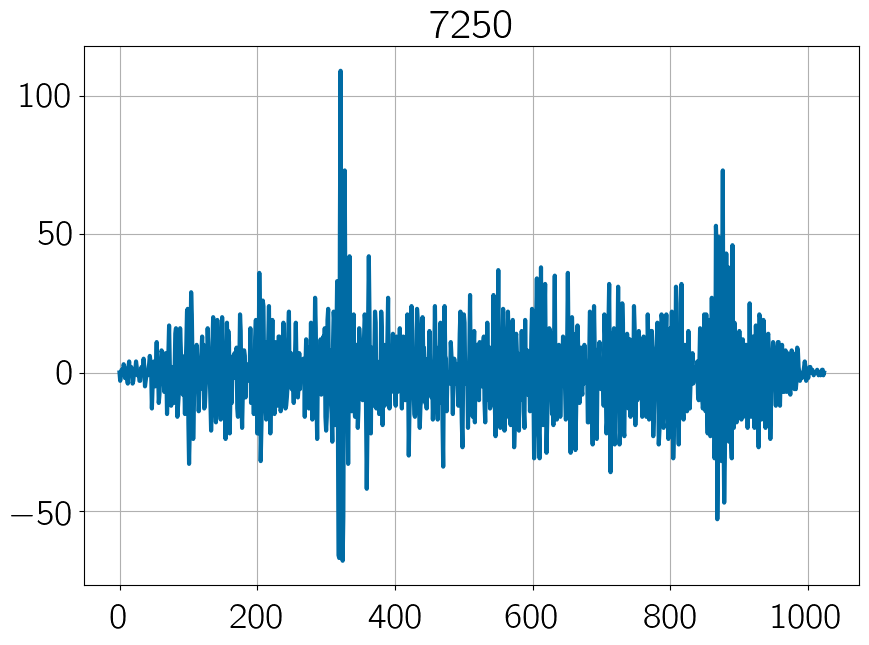

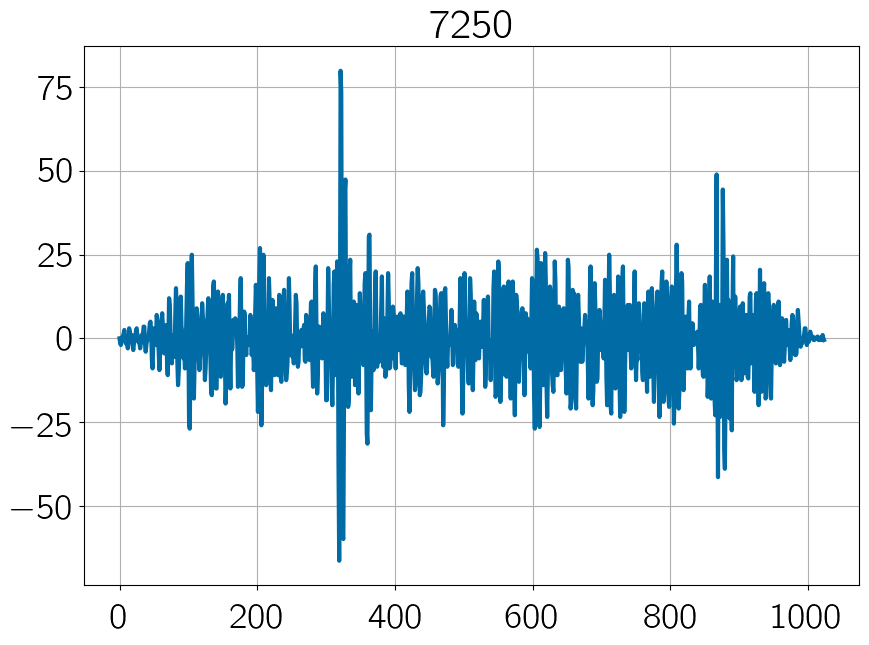

In [4]:
for i, bkg_trace in enumerate(bkg_traces):
    if np.max(bkg_trace[0]) > 90:
        plt.plot(bkg_trace[0])
        plt.title(i)
        plt.show()

        mean = np.convolve(bkg_trace[0], np.ones(2)/2, mode='same')

        plt.plot(mean)
        plt.title(i)
        plt.show()


Initiate FLT object and load in templates

Select a trace for testing

[12.89465005 12.21441771 16.25675244]


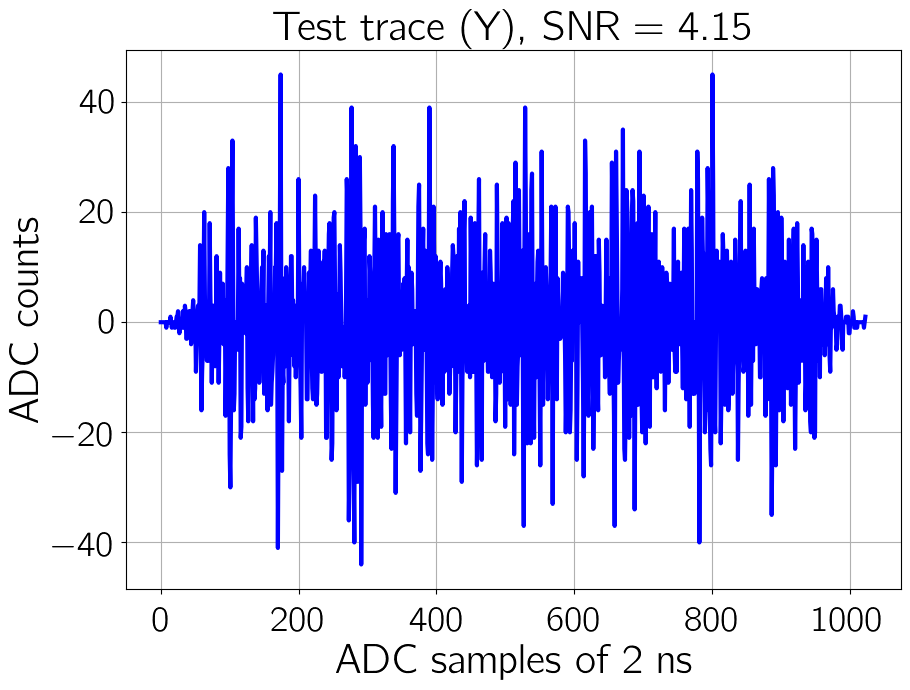

In [ ]:
idx_sig_test_trace = 14#611
sig_test_trace     = sig_traces[idx_sig_test_trace]

inj_time_test_trace = sig_inj_pulse_times[idx_sig_test_trace] + 15 # bug in DB construction 
t0_test_trace       = sig_pretrig_times[idx_sig_test_trace]
snr_test_trace      = sig_snr[idx_sig_test_trace]
max_trace           = np.max(np.abs(sig_test_trace),axis=1)
print(np.sqrt(np.mean(sig_test_trace[:,:500]**2,axis=1)))

pol = ['X','Y','Z']

if sig_pretrig_flags[idx_sig_test_trace] == 1:
    pol_idx = 0
elif sig_pretrig_flags[idx_sig_test_trace] == 2:
    pol_idx = 1
else:
    pol_idx = np.argmax(max_trace[:2])

# UNCOMMENT FOR 1D FLT TEST
pol_idx=1
sig_test_trace = sig_test_trace[pol_idx]

# sig_test_trace = bkg_traces[3178][0]
# t0_test_trace  = bkg_pretrig_times[3178]

fig, ax = plt.subplots()

ax.plot(sig_test_trace,color='b')

#ax.set_xlim([370,470])

title = 'Test trace ({}), SNR = {:.2f}'.format(pol[pol_idx],snr_test_trace)
ax.set_title(title)

ax.set_xlabel('ADC samples of 2 ns')
ax.set_ylabel('ADC counts')

#ax.axvline(t0_test_trace,color='k',ls=':')

plt.show()

In [5]:
print(sig_test_trace[:100])

[  0   0  -1  -1   0   1   0   0   0   0  -1   0   0   0   0   2   0  -1
   0   0  -1   0   1   0   0   0   0  -1  -3   0   3   0   1   0  -3  -6
   1   4   2   1  -2   0  -3   2   4  -4  -3   2   0   3   4   3  -9  -6
  -2   7  11  -5   0  -9  -8  23   4  -6  -5  -7  -6   4  15   6   0  -9
 -14 -12  18  13   5  -5  -6  -4  -4  -2 -12  15  28   6 -19 -18 -14   0
  22   6 -13  16  13 -14 -11 -11 -10   9]


### Save test trace for C++ comparisons
File: `/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_nutrig_gp13_train_seed_300.npz`

Entry: 611

Polarization: ALL

In [6]:
np.savetxt('/pbs/home/p/pcorrea/grand/nutrig/flt/template_flt_online/test_trace.txt',sig_traces[idx_sig_test_trace],fmt='%5i')

In [7]:
importlib.reload(flt.template_FLT)
from flt.template_FLT import *

In [8]:
template_dir = '/sps/grand/pcorrea/nutrig/template/lib/'
n_templates  = 96
pol          = 'XY'
rf_chain     = 'rfv2'

FLT = TemplateFLT()
FLT.load_templates(template_dir,n_templates,pol,rf_chain)

2024-12-12 00:26:59,553 [MainThread  ] [INFO   ]  Loaded 96 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_96_XY_rfv2.npz


In [9]:
from scipy.signal import correlate
import time

t0 = time.time()
c1 = np.correlate( sig_test_trace,FLT.templates_desampled[0,0] )
t1 = time.time() - t0
print(f'Time for numpy: {t1*1e3:.3f} ms')

t0 = time.time()
c2 = correlate( sig_test_trace,FLT.templates_desampled[0,0],method='direct' )
t1 = time.time() - t0
print(f'Time for scipy: {t1*1e3:.3f} ms')

print(np.max(c1),np.max(c2))

Time for numpy: 0.166 ms
Time for scipy: 0.292 ms
581.3261310213686 581.3261310213686


In [10]:
c1.size

925

2024-12-12 00:27:05,667 [MainThread  ] [INFO   ]  fitting time
[0.25320819 0.25326788 0.25362576 0.25326788 0.25328778 0.25337232
 0.25281484 0.25256058 0.24803587 0.24735945 0.24688536 0.24582685
 0.24549865 0.24285714 0.23767688 0.23760797 0.23696557 0.23467383
 0.23343049 0.23122359 0.22779299 0.22701742 0.22651189 0.22686755
 0.22753845 0.22771555 0.22756613 0.2271672  0.22635054 0.22568727
 0.22568727]
2024-12-12 00:27:05,674 [MainThread  ] [INFO   ]  fitting amplitude
2024-12-12 00:27:05,708 [MainThread  ] [INFO   ]  computing ts
0.06


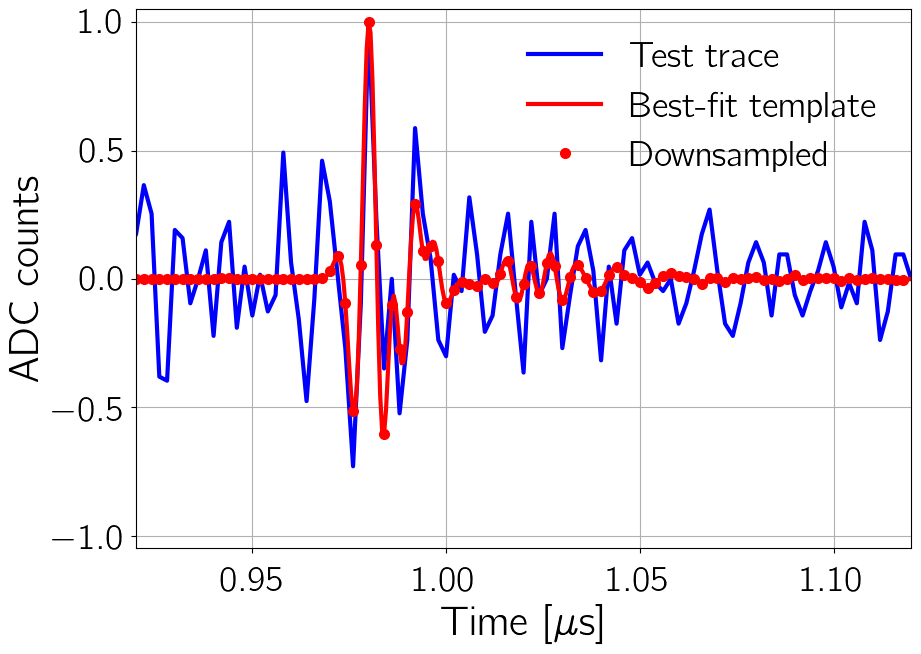

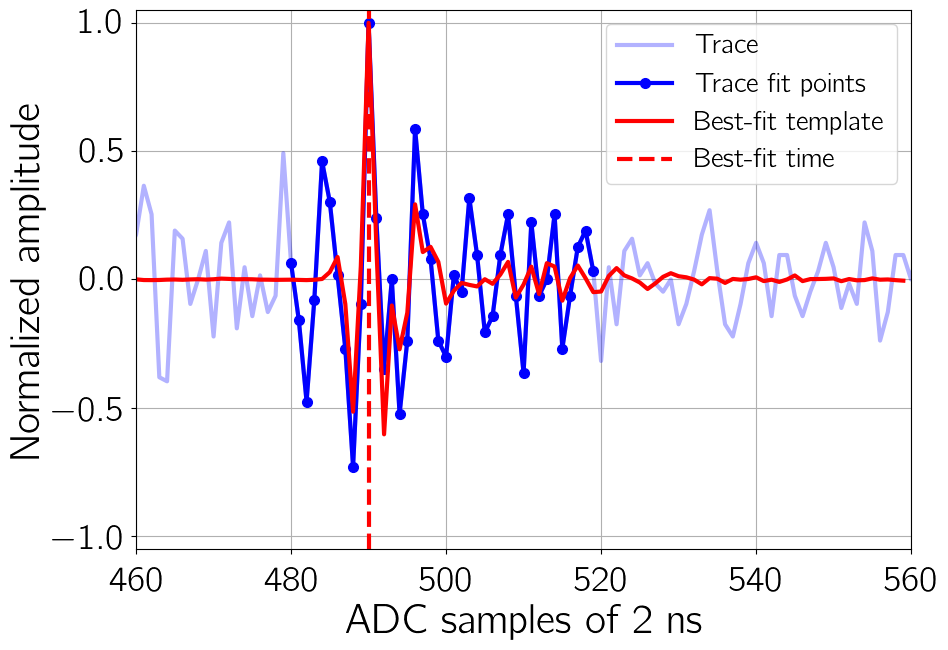

In [11]:
FLT.set_fit_window([-10,30])
FLT.set_corr_window([-15,15])

FLT.template_fit(sig_test_trace,t0_test_trace)

idx_best_fit  = FLT.idx_template_best_fit
time_best     = FLT.time_best[idx_best_fit] / FLT._adc_sampling_rate # [µs]
ampl_best     = FLT.ampl_best[idx_best_fit]
template_best = ampl_best*FLT.templates[idx_best_fit]

dt_start_to_peak  = FLT._template_peak_sample / FLT._adc_sampling_rate # [µs]
print(dt_start_to_peak)
dt_start_to_peak += FLT.idx_templates_desampled_best[idx_best_fit] / FLT._sim_sampling_rate  # [µs]

t_start    = time_best - dt_start_to_peak #+ 20e-4 # [µs]
t_end      = t_start + len(template_best)/FLT._sim_sampling_rate # [µs]
t_template = np.arange(t_start,t_end,1/FLT._sim_sampling_rate)#[:-1]

t_test_trace = np.arange(0,len(sig_test_trace))/FLT._adc_sampling_rate

i = int(FLT.idx_templates_desampled_best[idx_best_fit])
t_fit_points = t_template[i::4]
template_best_desampled = template_best[i::4]


fig, ax = plt.subplots()

ax.plot(t_test_trace,normalize(sig_test_trace),color='b',label='Test trace')
ax.plot(t_template,normalize(template_best),color='r',label='Best-fit template')
ax.plot(t_fit_points,normalize(template_best_desampled),color='r',linestyle='',marker='o',markersize=7,label='Downsampled')

ax.set_xlim([t_start,t_end])
#ax.set_xlim([3.16,3.24])
ax.set_ylim([-1.05,1.05])

ax.set_title('')

ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylabel('ADC counts')

ax.legend()

plt.show()


idcs_fit_points = FLT.time_best[idx_best_fit].astype(int) + np.arange(FLT._fit_window[0],FLT._fit_window[1]).astype(int)
sigma_fit       = np.abs( rms(sig_test_trace)**2 / np.where(sig_test_trace==0,1,sig_test_trace) )

t_fit_points = t_template[i::4]
template_best_desampled = template_best[i::4]

fig, ax = plt.subplots()

# ax.plot(t_test_trace,sig_test_trace,color='b',label='Test trace')
# ax.plot(t_test_trace[idcs_fit_points],sig_test_trace[idcs_fit_points],yerr=sigma_fit[idcs_fit_points])

ax.plot(t_test_trace*.5e3,normalize(sig_test_trace),color='b',alpha=.3,label='Trace')
ax.plot(t_test_trace[idcs_fit_points]*.5e3,normalize(sig_test_trace[idcs_fit_points]),color='b',label='Trace fit points',marker='o',markersize=7)
ax.plot(t_fit_points*.5e3,normalize(template_best_desampled),color='r',label='Best-fit template')
ax.axvline(FLT.time_best[idx_best_fit],color='r',ls='--',label='Best-fit time')

#ax.set_xlim([t_start,t_end])
# ax.set_xlim([650,750])
ax.set_xlim([FLT.time_best[idx_best_fit]-30,FLT.time_best[idx_best_fit]+70])
ax.set_ylim([-1.05,1.05])

ax.set_title('')

ax.set_xlabel('ADC samples of 2 ns')
ax.set_ylabel('Normalized amplitude')

#ax.text(705,-55,'GRAND preliminary', color='crimson')

ax.legend(frameon=True,framealpha=.8,fontsize=20)

if savefig:
    plot_name = 'template_fit_amplitude'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

In [12]:
idx_max = np.argmax(np.abs(FLT.corr_best))
idx_max, FLT.corr_best[idx_max], FLT.time_best[idx_max]
#np.abs(FLT.corr_best)

(89, 0.6434649832461916, 490.0)

In [13]:
idcs_fit_points = FLT.time_best[idx_best_fit] + np.arange(FLT._corr_window[0],FLT._corr_window[1])#/FLT._adc_sampling_rate # [µs]

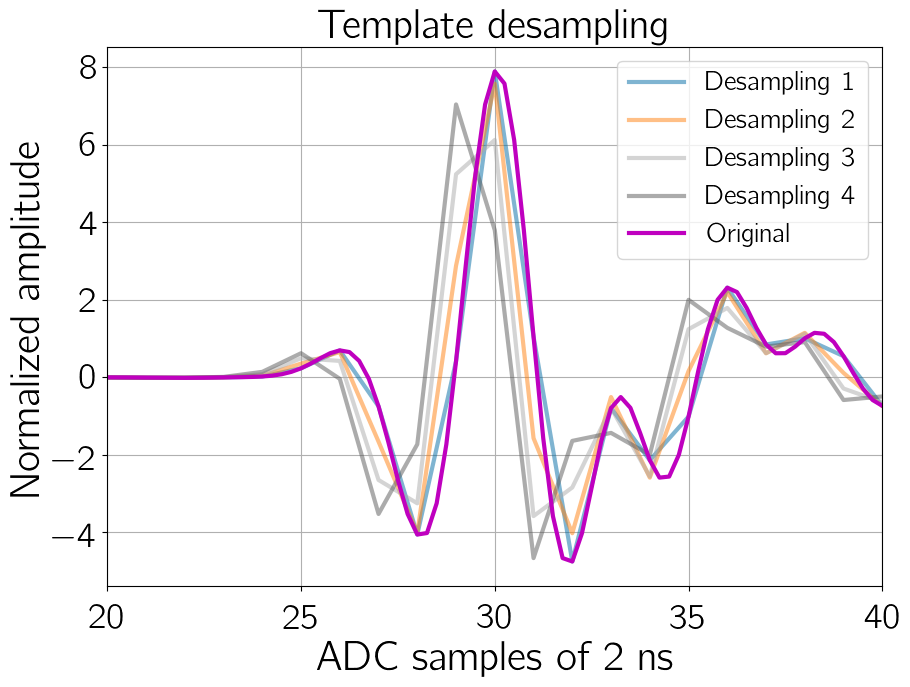

In [14]:
template_best_desampled = FLT.templates_desampled[idx_best_fit]

x1 = np.arange(0,400,1)
x2 = np.arange(0,100,1)
for i, temp in enumerate(template_best_desampled):
    plt.xlim([20,40])
    plt.plot(x1[::4]/4.,temp*ampl_best,alpha=.5,label=f'Desampling {i+1}') #x1[::4]

plt.plot(x1/4.,template_best,color='m',label='Original')
#plt.xlim([80,160])

plt.xlabel('ADC samples of 2 ns')
plt.ylabel('Normalized amplitude')

plt.title('Template desampling')

plt.legend(fontsize=20,framealpha=.8,frameon=True)

plt.show()

[15.95211585 15.95587666 15.97842295 15.95587666 15.95713007 15.96245595
 15.92733499 15.91131673 15.62625995 15.58364527 15.55377768 15.4870914
 15.46641523 15.3        14.97364351 14.96930192 14.92883117 14.78445129
 14.70612117 14.56708619 14.35095816 14.30209775 14.27024877 14.29265546
 14.33492239 14.3460796  14.33666628 14.31153381 14.26008415 14.21829807
 14.21829807]


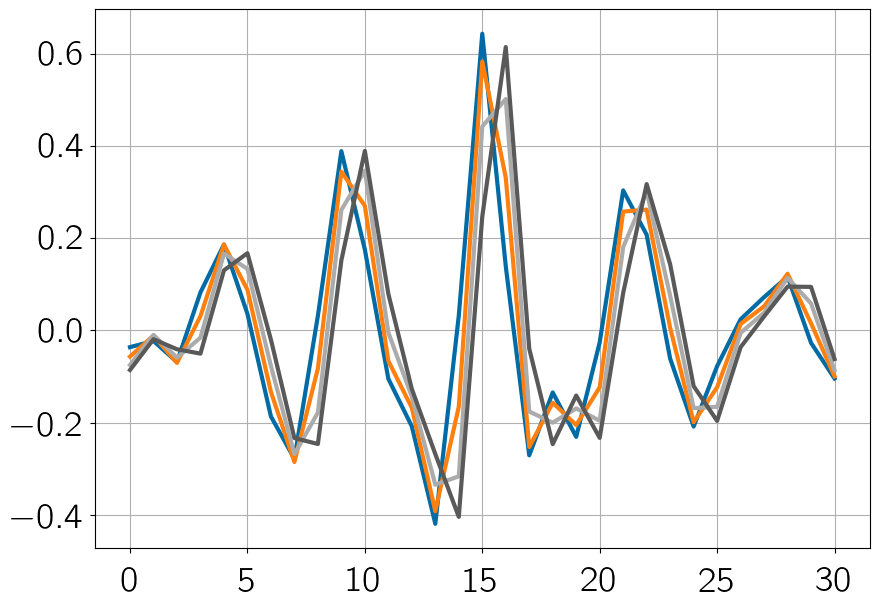

In [15]:
corr_window_start, corr_desampled = FLT._cross_corr_desampled(sig_test_trace,t0_test_trace)

corr_desampled_best_fit = corr_desampled[FLT.idx_template_best_fit]

for corr in corr_desampled_best_fit:
    plt.plot(corr)

corr_desampled_best = corr_desampled_best_fit[FLT.idx_templates_desampled_best[FLT.idx_template_best_fit]]

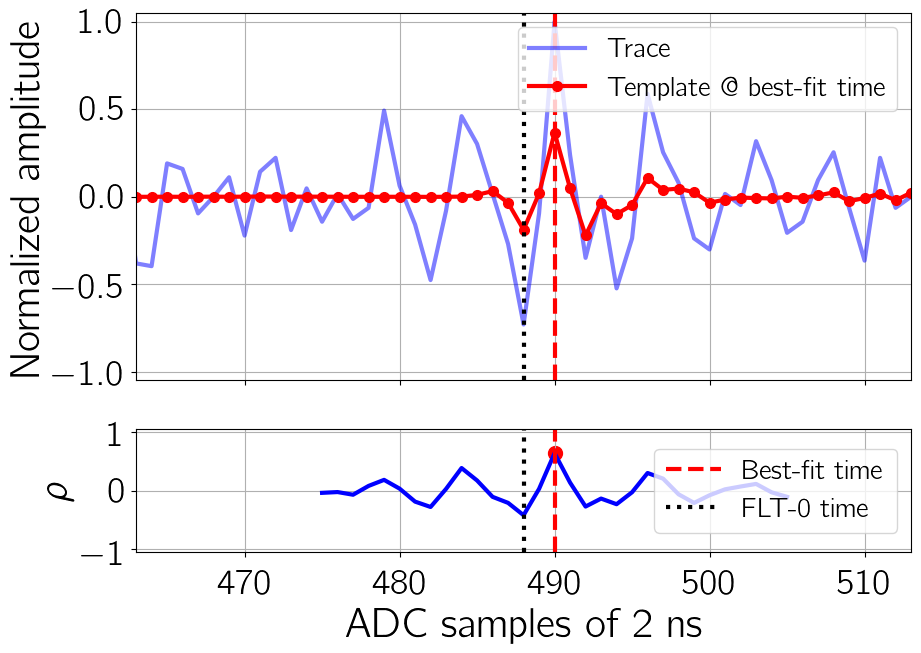

In [16]:
# t_corr  = np.arange(FLT.time_best[FLT.idx_template_best_fit]-FLT._template_peak_sample,
#                     FLT.time_best[FLT.idx_template_best_fit]-FLT._template_peak_sample+len(corr_desampled_best)) #/ FLT._adc_sampling_rate # [µs]

t_corr  = np.arange(corr_window_start,
                    corr_window_start+len(corr_desampled_best)) 

t_fit_start = FLT.time_best[idx_best_fit] - FLT._template_peak_sample
t_fit = np.arange(t_fit_start,t_fit_start+template_best_desampled.shape[-1])

k = 40



fig, ax = plt.subplots(2,1,sharex=True,height_ratios=[3,1])

ax[0].plot(normalize(sig_test_trace),color='b',alpha=.5,label='Trace')
ax[0].plot(t_fit,ampl_best/3*normalize(template_best_desampled[FLT.idx_templates_desampled_best[idx_best_fit]]),color='r',marker='o',markersize=7,alpha=1,label=r'Template @ best-fit time')
#ax[0].plot(t_fit+(t_corr[k]-FLT.time_best[idx_best_fit]),ampl_best/3*normalize(template_best_desampled[FLT.idx_templates_desampled_best[idx_best_fit]]),color='r',marker='o',markersize=7,alpha=.2,label=r'Template @ shifted time')

ax[1].plot(t_corr,corr_desampled_best,color='b')
ax[1].scatter(FLT.time_best[idx_best_fit],FLT.corr_best[idx_best_fit],color='r',marker='o',s=100) # -1
#ax[1].scatter(t_corr[k],corr_desampled_best[k],color='r',marker='o',s=100,alpha=.3)

ax[0].axvline(FLT.time_best[idx_best_fit],color='r',ls='--')
ax[1].axvline(FLT.time_best[idx_best_fit],color='r',ls='--',label='Best-fit time')

#ax[0].axvline(FLT.time_best[idx_best_fit],color='r',ls='--')
#ax[1].axvline(FLT.time_best[idx_best_fit],color='r',ls='-.',alpha=.2,label='Shifted time')

# ax[0].axvline(np.argmax(sig_test_trace),color='k',ls=':')
# ax[1].axvline(np.argmax(sig_test_trace),color='k',ls=':',label='Time of trace max')

ax[0].axvline(t0_test_trace,color='k',ls=':')
ax[1].axvline(t0_test_trace,color='k',ls=':',label='FLT-0 time')

ax[0].set_xlim([t0_test_trace-25,t0_test_trace+25])
# ax[0].set_xlim([FLT.time_best[idx_best_fit]-25,FLT.time_best[idx_best_fit]+25])

ax[0].set_ylim([-1.05,1.05])
ax[1].set_ylim([-1.05,1.05])

ax[1].set_xlabel(r'ADC samples of 2 ns')
ax[0].set_ylabel('Normalized amplitude')
ax[1].set_ylabel(r'$\rho$')

# ax[0].text(676,-80,'GRAND preliminary', color='crimson')
# ax[1].text(676,-80,'GRAND preliminary', color='crimson')

ax[0].legend(ncol=1,loc='upper right',frameon=True,framealpha=.8,fontsize=20)
ax[1].legend(ncol=1,loc='right',frameon=True,framealpha=.8,fontsize=20)

if savefig:
    plot_name = 'template_fit_time'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()


# fig, ax = plt.subplots(2,1,sharex=True)

# ax[0].plot(t_test_trace,sig_test_trace,color='b',label='Test trace')
# ax[0].plot(t_fit_points,template_best_desampled,color='r',label='Best-fit downsampled template')

# ax[1].plot(t_corr,np.abs(corr_desampled_best),color='r',label='Best-fit cross correlation')

# # ax.set_xlim([t_start,t_end])
# ax[0].set_xlim([t_corr[0],t_corr[-1]])

# ax[1].set_xlabel(r'Time [$\mu$s]')
# ax[0].set_ylabel('ADC counts')
# ax[1].set_ylabel(r'$|\rho|$')

# #ax.legend()

# plt.show()

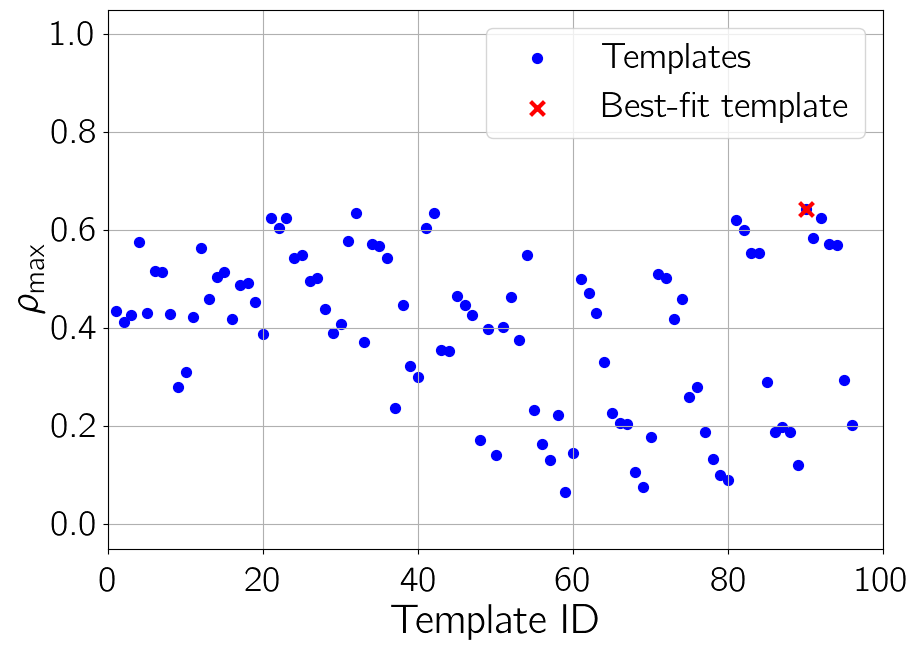

In [57]:
template_id = np.arange(len(FLT.templates))
plt.scatter(template_id,np.abs(FLT.corr_best),marker='o',color='b',label='Templates',s=50)
plt.scatter(FLT.idx_template_best_fit+1,np.abs(FLT.corr_best[FLT.idx_template_best_fit]),marker='x',s=100,color='r',label='Best-fit template')
plt.xlim([0,100])
plt.ylim([-0.05,1.05])
plt.xlabel('Template ID')
plt.ylabel(r'$\rho_{\max}$')
#plt.text(3,108,'GRAND preliminary', color='crimson')
plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'template_fit_chi2'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

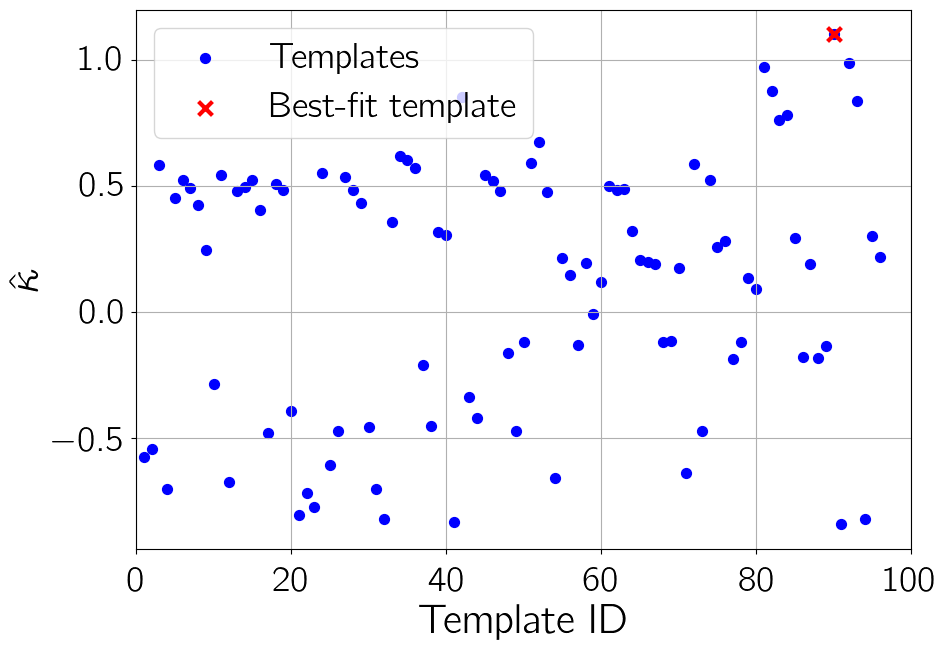

In [36]:
template_id = np.arange(len(FLT.templates)) + 1
plt.scatter(template_id,FLT.ampl_best,marker='o',color='b',label='Templates',s=50)
plt.scatter(FLT.idx_template_best_fit+1,FLT.ampl_best[FLT.idx_template_best_fit],marker='x',s=100,color='r',label='Best-fit template')
plt.xlim([0,100])
plt.xlabel('Template ID')
plt.ylabel(r'$\hat{\kappa}$')
#plt.text(3,108,'GRAND preliminary', color='crimson')
plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'template_fit_chi2'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

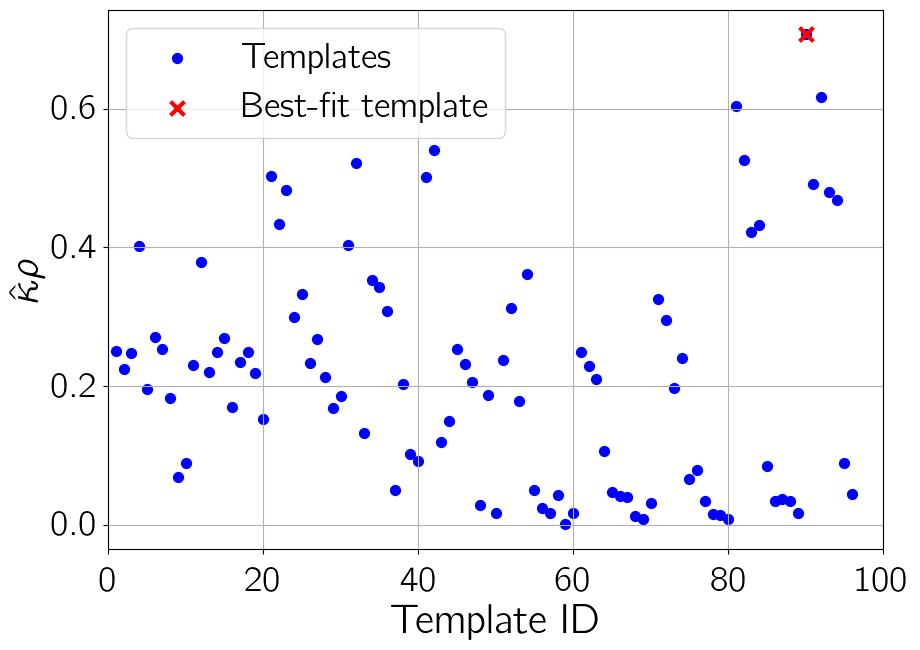

In [40]:
template_id = np.arange(len(FLT.templates)) + 1
plt.scatter(template_id,FLT.corr_best*FLT.ampl_best,marker='o',color='b',label='Templates',s=50)
plt.scatter(FLT.idx_template_best_fit+1,(FLT.corr_best*FLT.ampl_best)[FLT.idx_template_best_fit],marker='x',s=100,color='r',label='Best-fit template')
plt.xlim([0,100])
plt.xlabel('Template ID')
plt.ylabel(r'$\hat{\kappa} \rho$')
#plt.text(3,108,'GRAND preliminary', color='crimson')
plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'template_fit_chi2'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

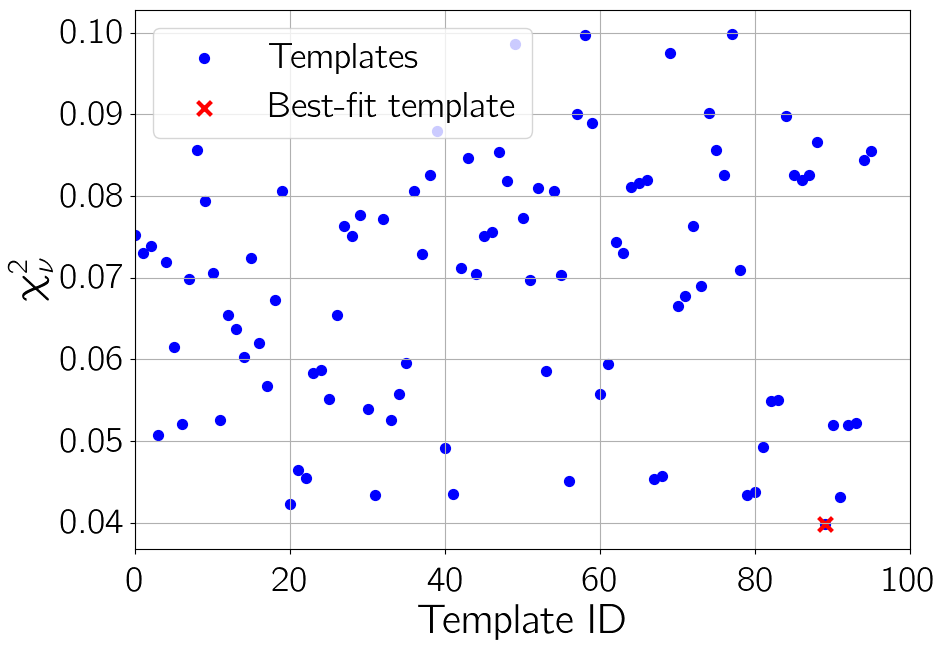

In [62]:
template_id = np.arange(len(FLT.templates))
plt.scatter(template_id,FLT.chi2,marker='o',color='b',label='Templates',s=50)
plt.scatter(FLT.idx_template_best_fit,FLT.chi2[FLT.idx_template_best_fit],marker='x',s=100,color='r',label='Best-fit template')
#plt.scatter(np.argmin(FLT.chi2),np.min(FLT.chi2),marker='x',s=100,color='r',label='Best-fit template')

plt.xlim([0,100])
plt.xlabel('Template ID')
plt.ylabel(r'$\chi_\nu^2$')
#plt.text(3,108,'GRAND preliminary', color='crimson')
plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'template_fit_chi2'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

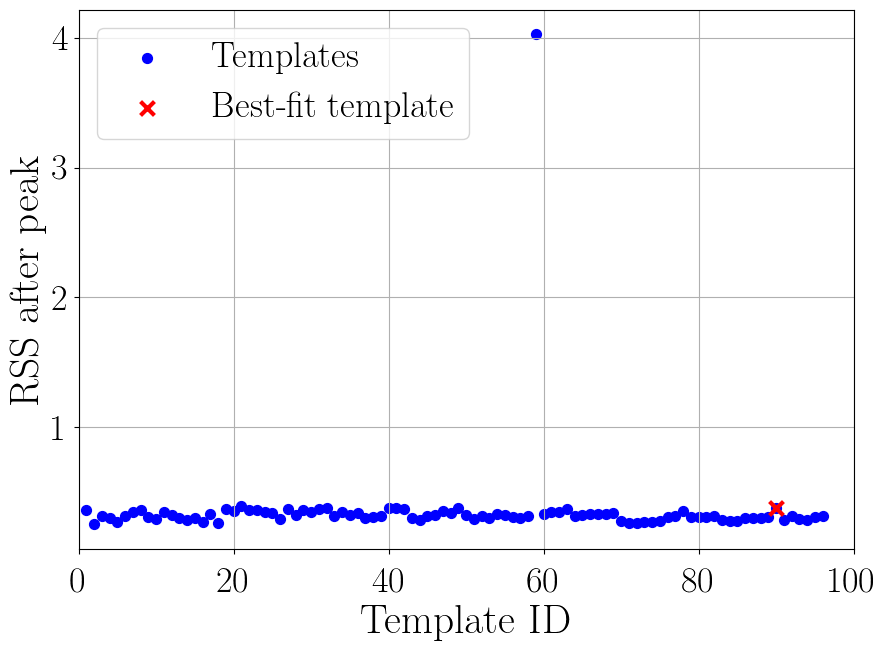

In [14]:
template_id = np.arange(len(FLT.templates)) + 1
plt.scatter(template_id,FLT.rss_post_peak,marker='o',color='b',label='Templates',s=50)
plt.scatter(FLT.idx_template_best_fit+1,FLT.rss_post_peak[FLT.idx_template_best_fit],marker='x',s=100,color='r',label='Best-fit template')
plt.xlim([0,100])
plt.xlabel('Template ID')
plt.ylabel(r'RSS after peak')
#plt.text(3,108,'GRAND preliminary', color='crimson')
plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'template_fit_chi2'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

Let's test on the whole signal sample!

The template fitting method attemps to identify air-shower pulses in a voltage trace $V$. This is done by fitting various templates $\mathcal{T}$ to the trace, taken from a library of normalized templates, i.e. $\int |\mathcal{T}(t)|\, \mathrm{d}t \equiv 1$. The method consists of three steps:

- For each template, determine the start time $t_s$ of the pulse. We assume that a pre-trigger is performed, giving us a guess $t_0$. We then determine cross-correlation of the template and the trace,
\begin{equation}
\rho(\tau) = \int \mathcal{T}(\tau)\, V(t+\tau)\, \mathrm{d}t,
\end{equation}
with $\tau$ ranging between $t_0 - 50$ ns and $t_0 + 50$ ns. The start time of the pulse is then found as $t_s = \argmax_{t} |\rho(t)|$, i.e. it is the start time of the pulse that maximizes the cross-correlation $|\rho|$.

- For each template, perform the template fit at the determined $t_{s,\mathrm{best}}$. We only allow one degree of freedom to the fit, i.e. the amplitude $\kappa$. More specifically, we fit the function $\kappa \mathcal{T}(t)$ to the trace $V(t)$ for $t \in [t_s+40~\mathrm{ns},t_s+90~\mathrm{ns}]$. Note that by construction, the peak of the template corresponds to $t_s+60~\mathrm{ns}$. To give more relative weight to the pulse peak, we estimate the uncertainty of each sample point as $\sigma(t) = \mathrm{STD^2}/V(t)$, with $\mathrm{STD}$ the standard deviation of the entire trace.

- Finally, the best template is chosen as the one with the smallest reduced $\chi_\nu^2$. The corresponding best-fit amplitude and cross-correlation are then combined to yield a test statistic $\mathrm{TS} = \log_{10} |\kappa_{\mathrm{best}} \rho|$.


In [ ]:
importlib.reload(nutrig.flt.scripts.template_FLT)

template_dir = '/sps/grand/pcorrea/nutrig/template/lib/'
n_templates  = (96,96,94)
#pol          = 'XY'
rf_chain     = 'rfv2'

FLT = TemplateFLT3D()
FLT.load_templates(template_dir,n_templates,rf_chain)

2024-06-26 13:04:11,057 [MainThread  ] [INFO   ]  Loaded 96 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_96_XY_rfv2.npz
2024-06-26 13:04:11,057 [MainThread  ] [INFO   ]  Loaded 96 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_96_XY_rfv2.npz
2024-06-26 13:04:11,061 [MainThread  ] [INFO   ]  Loaded 96 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_96_XY_rfv2.npz
2024-06-26 13:04:11,061 [MainThread  ] [INFO   ]  Loaded 96 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_96_XY_rfv2.npz
2024-06-26 13:04:11,065 [MainThread  ] [INFO   ]  Loaded 94 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_94_Z_rfv2.npz
2024-06-26 13:04:11,065 [MainThread  ] [INFO   ]  Loaded 94 templates from /sps/grand/pcorrea/nutrig/template/lib/templates_94_Z_rfv2.npz


In [ ]:
FLT.template_fit(sig_test_trace,t0_test_trace)

NameError: name 'sig_test_trace' is not defined

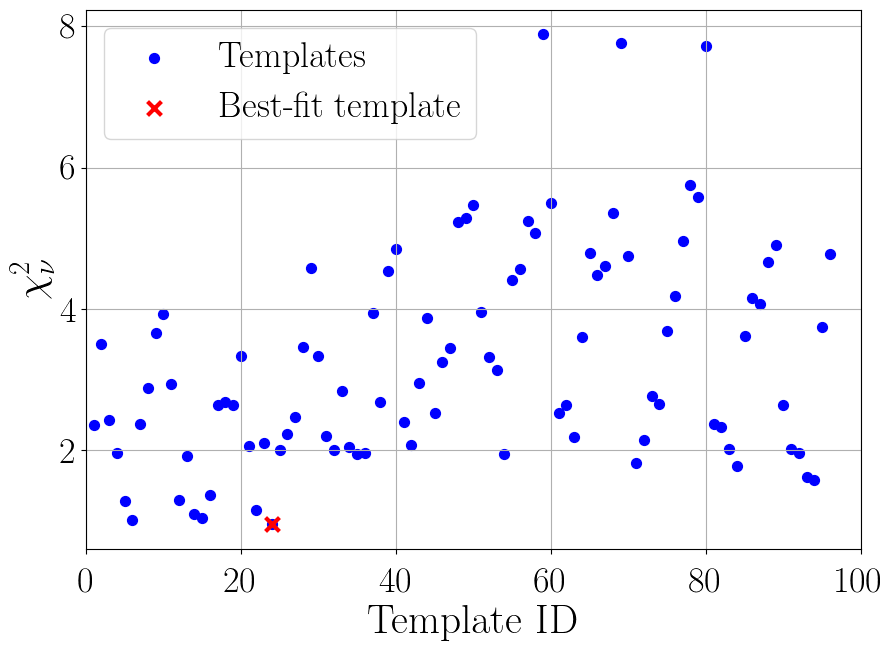

In [ ]:
template_id = np.arange(len(FLT.FLT_X.templates)) + 1
plt.scatter(template_id,FLT.FLT_X.chi2,marker='o',color='b',label='Templates',s=50)
plt.scatter(FLT.FLT_X.idx_template_best_fit+1,FLT.FLT_X.chi2[FLT.FLT_X.idx_template_best_fit],marker='x',s=100,color='r',label='Best-fit template')
plt.xlim([0,100])
plt.xlabel('Template ID')
plt.ylabel(r'$\chi_\nu^2$')
#plt.text(3,108,'GRAND preliminary', color='crimson')
plt.legend(frameon=True,framealpha=.8)

if savefig:
    plot_name = 'template_fit_chi2'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()